# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

## Load Libraries

In [102]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

## Data Preprocessing

Keep only useful columns, check for nulls, check if dataset is balanced -> balance dataset

Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [2]:
# Read data and merge it into one dataset
data = pd.read_csv("https://raw.githubusercontent.com/steliossid/covid19-classification/main/data.csv", encoding="latin")

not_whole_dataset = False
if not_whole_dataset:
    data = data.loc[:1000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
# Check if there are null values
data.isnull().values.any()

False

In [5]:
data.shape

(44955, 2)

In [6]:
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

### Balance Dataset

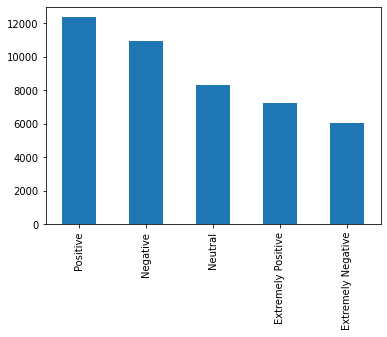

In [7]:
data.Sentiment.value_counts().plot(kind='bar');

In [8]:
data.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

Dataset is not balanced.

In [9]:
# Balance dataset
count_min = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_min)
df_Neg = data[data.Sentiment == "Negative"].sample(count_min)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_min)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_min)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [10]:
data_balanced.Sentiment.value_counts()

Negative              6073
Extremely Positive    6073
Neutral               6073
Extremely Negative    6073
Positive              6073
Name: Sentiment, dtype: int64

### Natural Language Processing (NLP)

lowercase all words, remove stopwords, punctuations, numbers, links, hashtags, mentions etc.

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
  # lowercase all words
  # discard stopwords
  # discard non-alphabetic characters
  # discard tokens with less than 3 characters
  # discard words in words2remove
  # return word lemma
  doc = nlp(text)
  words2remove = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
  return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2 and token.lemma_.lower() not in words2remove]

In [12]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data_balanced.head()

,OriginalTweet,Sentiment,ProcessedTweet
38009,*FILL OUR PLATES*\r\r\nwith dignity is essenti...,Positive,fill plates dignity essential fight pandemic t...
15278,"If soap and water are not readily available, u...",Positive,soap water readily available use alcohol base ...
18088,Anyone with concerns about a business engaging...,Positive,concern business engage pandemic charge excess...
36758,We are WIPED out after the TP-ROLL UP!! ???\r\...,Positive,wiped roll thanks obey socialdistancing guidel...
37439,@latimesopinion @RebekahLSanders @kerryc_latim...,Positive,hearyee hearyee ccc course online consumer evi...


Some rows are empty after text processing, so we exclude them

In [13]:
is_empty = data_balanced.ProcessedTweet==""
data_balanced = data_balanced[is_empty==False]

Minor change in the balance of the classes, no need to rebalance the classes

In [14]:
data_balanced.Sentiment.value_counts()

Negative              6073
Extremely Positive    6073
Extremely Negative    6073
Positive              6072
Neutral               6041
Name: Sentiment, dtype: int64

In [15]:
data = data_balanced.copy()
data.shape

(30332, 3)

## Statistics

### Number of words in tweet

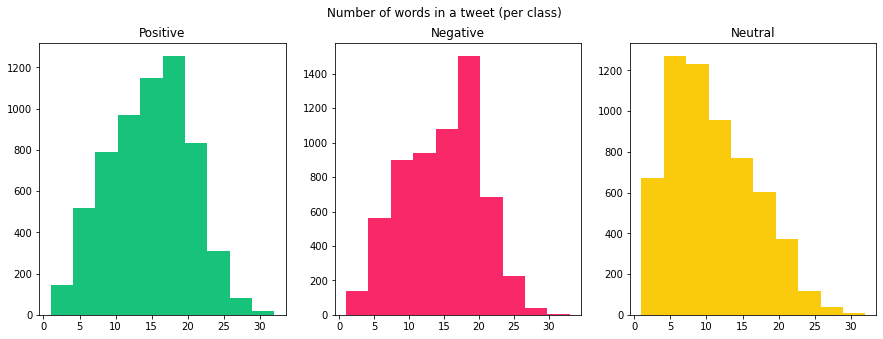

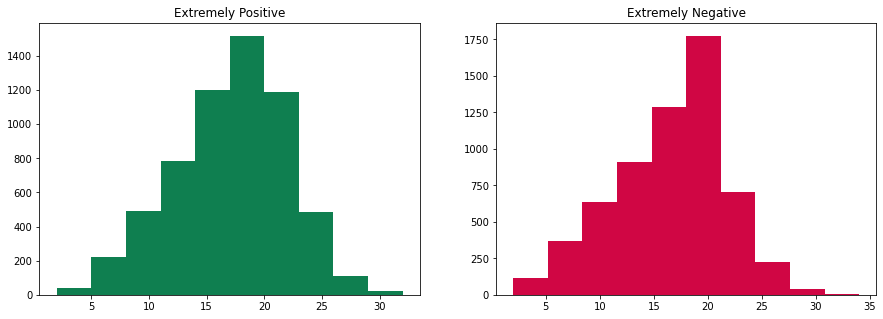

In [16]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
fig2,(ax4, ax5)=plt.subplots(1,2,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax4.hist(len_expos, color='#0f7f50')
ax4.set_title('Extremely Positive')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax5.hist(len_exneg, color='#d00644')
ax5.set_title('Extremely Negative')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

In [17]:
plt.savefig('number_words_tweet.jpg')

<Figure size 432x288 with 0 Axes>

### Wordclouds

In [18]:
def create_wordlist(sentiment):
    wordlist=[]
    
    if sentiment == "whole_dataset":
      proc_tweet = data["ProcessedTweet"].str.split()
    else:
      proc_tweet = data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split()
    for line in proc_tweet:
        for word in line:
          wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    if sentiment=="whole_dataset":
      plt.title("Whole dataset wordcloud")
    else:
      plt.title(sentiment + " " + "wordcloud")
    plt.show()

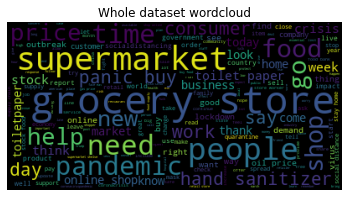

In [19]:
create_wordcloud("whole_dataset")

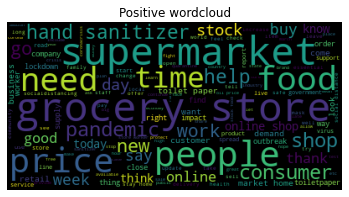

In [20]:
create_wordcloud("Positive")

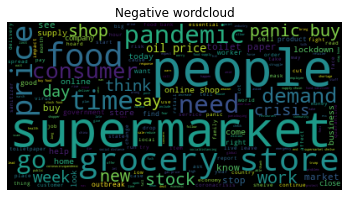

In [21]:
create_wordcloud("Negative")

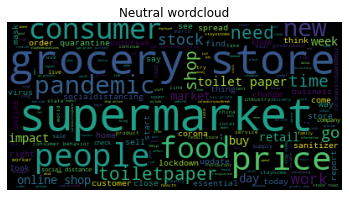

In [22]:
create_wordcloud("Neutral")

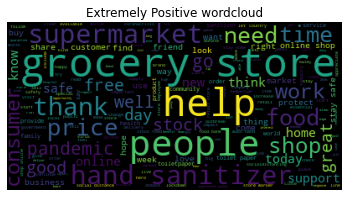

In [23]:
create_wordcloud("Extremely Positive")

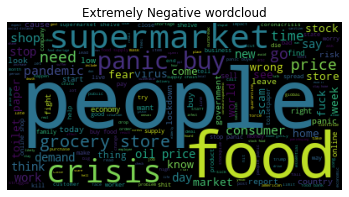

In [24]:
create_wordcloud("Extremely Negative")

In [25]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)

    most_common = counter.most_common(n_common)
    count = [word[0] for word in most_common][::-1]
    words = [word[1] for word in most_common][::-1]
    plt.barh(count, words)
    plt.title(sentiment)
    plt.show()

### Uni-grams

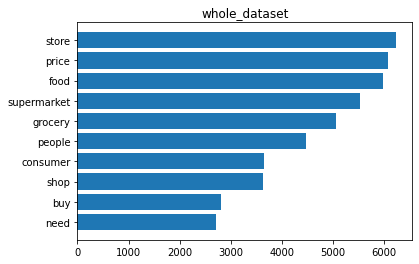

In [26]:


most_common_ngrams("whole_dataset")

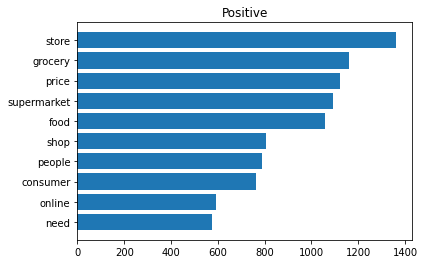

In [27]:
most_common_ngrams("Positive")

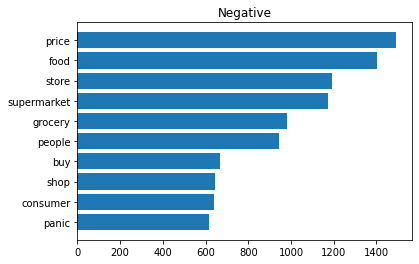

In [28]:
most_common_ngrams("Negative")

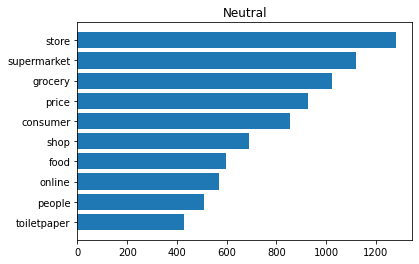

In [29]:
most_common_ngrams("Neutral")

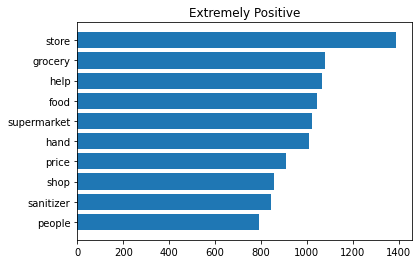

In [30]:
most_common_ngrams("Extremely Positive")

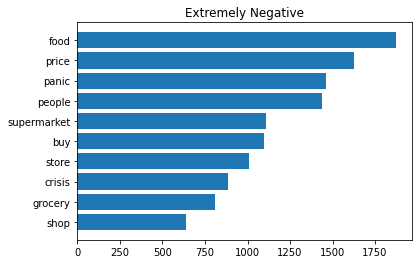

In [31]:
most_common_ngrams("Extremely Negative")

### Bi-grams

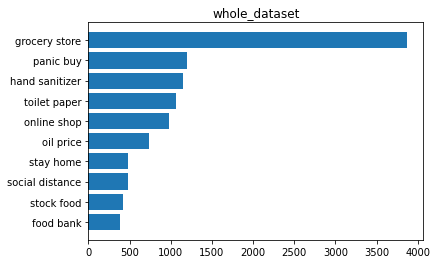

In [32]:
most_common_ngrams("whole_dataset", n_gram=2)

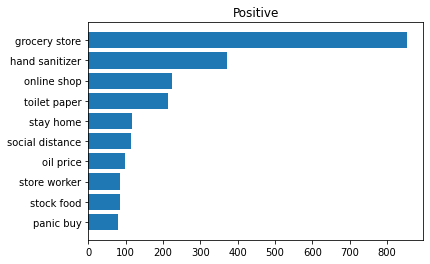

In [33]:
most_common_ngrams("Positive", n_gram=2)

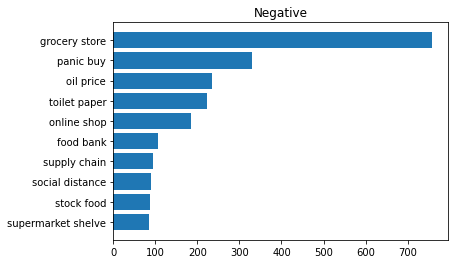

In [34]:
most_common_ngrams("Negative", n_gram=2)

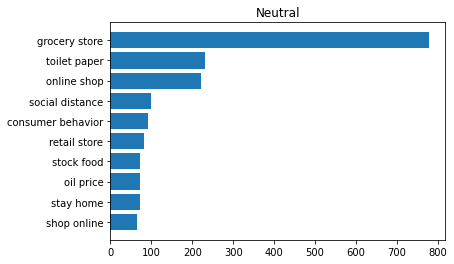

In [35]:
most_common_ngrams("Neutral", n_gram=2)

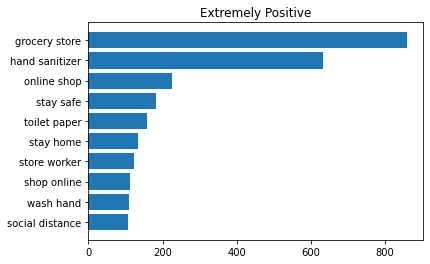

In [36]:
most_common_ngrams("Extremely Positive", n_gram=2)

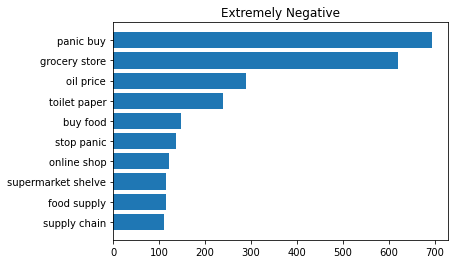

In [37]:
most_common_ngrams("Extremely Negative", n_gram=2)

## Models

In [38]:
# Split train, test
X = data.ProcessedTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)
count_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9)

def print_results(model):
  model.fit(X_train, y_train)
  y_predicted = model.predict(X_test)
  print(classification_report(y_test, y_predicted))

### Multinomial Naive Bayes

In [39]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', count_vectorizer),
    ('predictor', MultinomialNB())
])

parameters = {
    "predictor__alpha": (0.1, 1)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', MultinomialNB(alpha=grid_search.best_params_["predictor__alpha"]))
])

print_results(model)

predictor__alpha: 1
                    precision    recall  f1-score   support

Extremely Negative       0.54      0.67      0.60      1204
Extremely Positive       0.55      0.68      0.61      1256
          Negative       0.38      0.33      0.35      1205
           Neutral       0.59      0.49      0.54      1210
          Positive       0.36      0.30      0.33      1192

          accuracy                           0.50      6067
         macro avg       0.49      0.49      0.49      6067
      weighted avg       0.49      0.50      0.49      6067



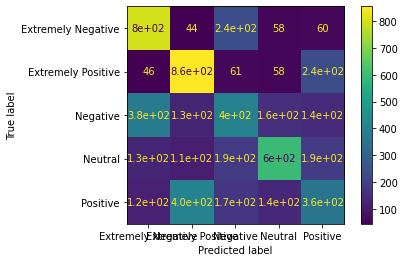

In [40]:
plot_confusion_matrix(model, X_test, y_test)

### Logistic Regression

In [41]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(max_iter=10000))
])

parameters = {
    "predictor__C": (1,3,5),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LogisticRegression(penalty=grid_search.best_params_["predictor__penalty"],
                                     C=grid_search.best_params_["predictor__C"],
                                     max_iter=10000))
])

print_results(model)

predictor__C: 3
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.67      0.69      0.68      1204
Extremely Positive       0.69      0.72      0.70      1256
          Negative       0.43      0.38      0.41      1205
           Neutral       0.61      0.70      0.65      1210
          Positive       0.43      0.39      0.41      1192

          accuracy                           0.58      6067
         macro avg       0.57      0.58      0.57      6067
      weighted avg       0.57      0.58      0.57      6067



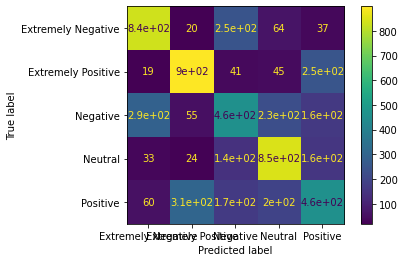

In [42]:
plot_confusion_matrix(model, X_test, y_test)

### Random Forest Classifier

In [43]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier())
])

parameters = {
    "predictor__max_depth": (1,5,10,50),
    "predictor__n_estimators": (5,10,100,500)
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', RandomForestClassifier(max_depth=grid_search.best_params_["predictor__max_depth"], 
                                         n_estimators=grid_search.best_params_["predictor__n_estimators"],
                                         class_weight="balanced"))
])

print_results(model)

predictor__max_depth: 50
predictor__n_estimators: 500
                    precision    recall  f1-score   support

Extremely Negative       0.62      0.72      0.67      1204
Extremely Positive       0.60      0.76      0.67      1256
          Negative       0.45      0.22      0.30      1205
           Neutral       0.48      0.86      0.62      1210
          Positive       0.49      0.13      0.20      1192

          accuracy                           0.54      6067
         macro avg       0.53      0.54      0.49      6067
      weighted avg       0.53      0.54      0.49      6067



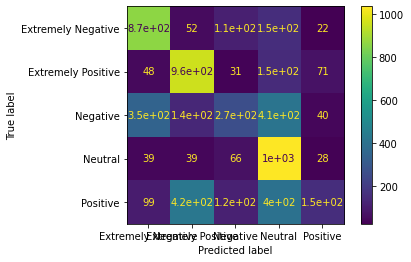

In [44]:
plot_confusion_matrix(model, X_test, y_test)

### Decision Tree Classifier


Fine-tuning hyperparameters with Grid Search takes a lot of time, so the default values of DecisionTreeClassifier were used.

In [45]:
# Find optimal parameters - very slow!
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', DecisionTreeClassifier())
# ])

# parameters = {
#     "predictor__criterion": ("gini", "entropy"),
#     "predictor__max_depth": range(1,10),
#     "predictor__min_samples_split": range(1,10),
#     "predictor__min_samples_leaf": range(1,5),
# }


# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', DecisionTreeClassifier(class_weight="balanced"))
])

print_results(model)

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.50      0.53      1204
Extremely Positive       0.56      0.54      0.55      1256
          Negative       0.36      0.35      0.36      1205
           Neutral       0.54      0.66      0.60      1210
          Positive       0.31      0.30      0.30      1192

          accuracy                           0.47      6067
         macro avg       0.47      0.47      0.47      6067
      weighted avg       0.47      0.47      0.47      6067



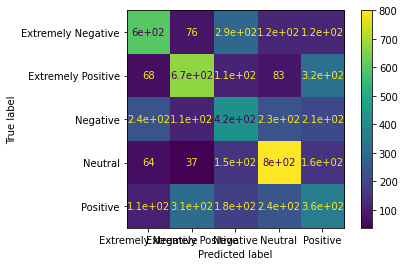

In [46]:
plot_confusion_matrix(model, X_test, y_test)

### Linear Support Vector Classifier (SVC)

In [47]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(max_iter=10000))
])

parameters = {
    "predictor__penalty": ("l1", "l2")
}


grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', LinearSVC(penalty=grid_search.best_params_["predictor__penalty"],
                            class_weight="balanced", max_iter=10000))
])

print_results(model)

predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.65      0.72      0.68      1204
Extremely Positive       0.67      0.74      0.70      1256
          Negative       0.41      0.34      0.37      1205
           Neutral       0.61      0.67      0.64      1210
          Positive       0.40      0.34      0.37      1192

          accuracy                           0.56      6067
         macro avg       0.55      0.56      0.55      6067
      weighted avg       0.55      0.56      0.55      6067



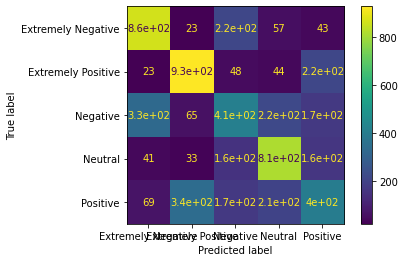

In [48]:
plot_confusion_matrix(model, X_test, y_test)

### Stochastic Gradient Descent (SGD) Classifier

In [49]:
# Find optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier())
])

parameters = {
    "predictor__alpha": (0.0001, 0.001, 0.01, 0.1, 1),
    "predictor__penalty": ("l1", "l2")
}

grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

#print("Grid Search Best Score: " + str(grid_search.best_score_))

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', SGDClassifier(alpha=grid_search.best_params_["predictor__alpha"], 
                                penalty=grid_search.best_params_["predictor__penalty"],
                                class_weight="balanced"))
])

print_results(model)

predictor__alpha: 0.0001
predictor__penalty: 'l2'
                    precision    recall  f1-score   support

Extremely Negative       0.57      0.85      0.69      1204
Extremely Positive       0.59      0.87      0.70      1256
          Negative       0.49      0.18      0.26      1205
           Neutral       0.58      0.78      0.67      1210
          Positive       0.48      0.14      0.22      1192

          accuracy                           0.57      6067
         macro avg       0.54      0.56      0.51      6067
      weighted avg       0.54      0.57      0.51      6067



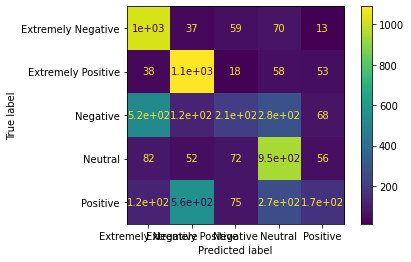

In [50]:
plot_confusion_matrix(model, X_test, y_test)

### Extreme Gradient Boosting Classifier (XGB)

Fine-tuning hyperparameters with Grid Search takes a lot of time, so custom values of XGBClassifier were used.

In [51]:
# # Find optimal parameters - very slow!
# model = Pipeline([
#     ('vectorizer', tfidf_vectorizer),
#     ('predictor', XGBClassifier())
# ])

# parameters = {
#     "predictor__learning_rate": (0.0001, 0.001, 0.01, 0.1),
#     "predictor__max_depth": (1,3,5,7),
#     "predictor__no_estimators": (5,10,100,500)
# }

# grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
# grid_search = grid_search.fit(X_train, y_train)

# print("Grid Search Best Score: " + str(grid_search.best_score_))

# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, grid_search.best_params_[param_name]))
    
# Using optimal parameters
model = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('predictor', XGBClassifier(learning_rate=0.1, max_depth=7, no_estimators=200,
                                colsample_bytree=0.8, subsample=0.8, nthread=10))
])

print_results(model)

                    precision    recall  f1-score   support

Extremely Negative       0.65      0.62      0.63      1204
Extremely Positive       0.63      0.64      0.64      1256
          Negative       0.41      0.28      0.33      1205
           Neutral       0.48      0.83      0.61      1210
          Positive       0.41      0.24      0.30      1192

          accuracy                           0.53      6067
         macro avg       0.52      0.52      0.50      6067
      weighted avg       0.52      0.53      0.51      6067



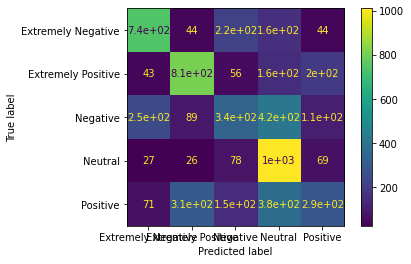

In [52]:
plot_confusion_matrix(model, X_test, y_test)

### Recurrent Neural Network (RNN)

In [139]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index)+1

X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

encoding = {'Extremely Negative': 0,
            'Extremely Positive': 1,
            'Negative': 2,
            'Neutral': 3,
            'Positive': 4
           }
labels = ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
y_train.replace(encoding, inplace=True)
y_test.replace(encoding, inplace=True)

embedding_dim = 16
hidden_dim = 256

def build_model(embedding_dim, hidden_dim):
  model = tf.keras.Sequential()
  model.add(L.Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]))
  model.add(L.Bidirectional(L.LSTM(hidden_dim,return_sequences=True)))
  model.add(L.GlobalMaxPool1D())
  model.add(L.Dropout(0.4))
  model.add(L.Dense(64, activation="relu"))
  model.add(L.Dropout(0.4))
  model.add(L.Dense(5, activation='softmax'))

  model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), 
                optimizer='adam', metrics=['accuracy'])
  return model

tf.keras.backend.clear_session()
model = build_model(embedding_dim, hidden_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 16)            427872    
_________________________________________________________________
bidirectional (Bidirectional (None, 34, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [140]:
epochs = 4
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.12)

Epoch 1/4
313/313 [==============================] - 8s 17ms/step - loss: 1.5230 - accuracy: 0.2954 - val_loss: 1.1386 - val_accuracy: 0.5421
Epoch 2/4
313/313 [==============================] - 4s 14ms/step - loss: 0.9725 - accuracy: 0.6232 - val_loss: 0.9136 - val_accuracy: 0.6436
Epoch 3/4
313/313 [==============================] - 4s 13ms/step - loss: 0.6875 - accuracy: 0.7592 - val_loss: 1.0008 - val_accuracy: 0.6337
Epoch 4/4
313/313 [==============================] - 4s 14ms/step - loss: 0.5338 - accuracy: 0.8190 - val_loss: 1.0106 - val_accuracy: 0.6509


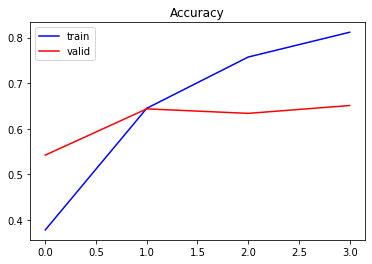

In [141]:
accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

epochs_range = range(epochs)

plt.plot(epochs_range, accuracy,'blue', label='train')
plt.plot(epochs_range, valid_accuracy, 'red', label='valid')
plt.title("Accuracy")
plt.legend()
plt.show()

In [142]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=labels))

                    precision    recall  f1-score   support

Extremely Negative       0.73      0.77      0.75      1529
Extremely Positive       0.78      0.69      0.73      1552
          Negative       0.49      0.52      0.50      1501
           Neutral       0.81      0.64      0.71      1514
          Positive       0.50      0.60      0.55      1487

          accuracy                           0.65      7583
         macro avg       0.66      0.65      0.65      7583
      weighted avg       0.66      0.65      0.65      7583



## Results

| Model                                        | Accuracy |
|----------------------------------------------|----------|
| Recurrent Neural Network (RNN)               | 0.68     |
| Logistic Regression                          | 0.58     |
| Stochastic Gradient Descent (SGD) Classifier | 0.57     |
| Linear Support Vector Classifier (SVC)       | 0.56     |
| Random Forest Classifier                     | 0.54     |
| Extreme Gradient Boosting Classifier (XGB)   | 0.53     |
| Multinomial Naive Bayes                      | 0.50     |
| Decision Tree Classifier                     | 0.46     |

